In [11]:
import torch
import torchvision
import pandas as pd
import os
from tqdm import tqdm
import pydicom
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload all
    
from utils import read_images
from datasets import SimpleFrameSelectionDataset
from models import resnet_binary

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
images = read_images(ids="test")



In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet_binary()
model.load_state_dict(torch.load('weights/frame_selection.pth'))
model.eval()
model = model.to(device)

transform = SimpleFrameSelectionDataset({}).transform

In [8]:
df = pd.read_csv("data/framerejectionfeedback.csv")
sel = df.groupby("IMAGE_ID")["SELECTEDFRAME"].apply(list)
rej = df.groupby("IMAGE_ID")["REJECTEDFRAME"].apply(list)

df = pd.DataFrame({"selected": sel, "rejected": rej})

In [60]:
def get_scores(img_id, smoothen=None):
    img = images[img_id] 
    img = transform(img.transpose(1,2,0)).to(device).unsqueeze(1)
    probs = torch.sigmoid(model(img))[:, 1]
    probs = probs.cpu().numpy()

    if smoothen is not None:
        kernel = np.hamming(smoothen)
        probs = np.convolve(probs, kernel/kernel.sum(), mode='same')

    return probs

In [61]:
stats = {}

for img_id, row in df.iterrows():
    if img_id not in images:
        continue
    scores = get_scores(img_id)
    top_n = np.argmax(scores)
    stats[img_id] = {
        "dist_from_selected": min(abs(top_n - n) for n in row["selected"]),
        "dist_from_rejected": min(abs(top_n - n) for n in row["rejected"]),
        "top_n_pos": min(list(np.argsort(-scores)).index(n) for n in row["selected"]),
        "seq_len": images[img_id].shape[0]
    }

stats_df = pd.DataFrame(stats).T
stats_df

,dist_from_selected,dist_from_rejected,top_n_pos,seq_len
131aedfhs6pnf1fvtvp493b3tudjsae022,30,38,16,80
131aedfhs6pnf1fvtvp493b3tufm4gzi22,3,38,17,60
131aedfhs6pnf1fvtvp493b3tuvd4nqc22,19,54,28,63
131aedfhs6pnf1fvtvp49h4bhdjeabmt22,2,26,17,59
131aedfhs6pnf1fvtvp49h4bhdjmrenr22,4,45,11,51
...,...,...,...,...
131aedfht3wfgufvmycqzlkyr2c49uc,8,34,6,41
131aedfht3wfgufvmycqzlkysfzfv98,6,39,6,43
131aedfht3wfgufvmycqzlkyts4d7hi,3,26,9,39
131aedfht3wfgufvmycqzlkz0rcviu2,7,26,6,32


In [48]:
images["131aedfhs6pnf1fvtvp49h4bhdjeabmt22"].shape

(59, 512, 512)

In [45]:
def plot_frame_selection(img_id):
    probs = get_scores(img_id)

    plt.figure(figsize=(12, 3)) 
    ax = sns.barplot(x=np.arange(len(probs)), y=probs, color="skyblue", width=0.8)
    ax.set_xticks(ax.get_xticks()[::2])

    max_prob_index = np.argmax(probs)
    ax.patches[max_prob_index].set_facecolor('blue')

    try:
        rejected = df.loc[img_id, "REJECTEDFRAME"]
        selected = df.loc[img_id, "SELECTEDFRAME"]
        for r in rejected.values if type(rejected)!=np.int64 else [rejected]:
            plt.axvline(x=r, color='red', linestyle='--', label='Rejected')
        for s in selected.values if type(selected)!=np.int64 else [selected]:
            plt.axvline(x=s, color='green', linestyle='--', label='Selected')
    except KeyError as e:
        print(f"{e} not found in framerejectionfeedback")

    plt.title('Model Output Probabilities')
    plt.show()

'REJECTEDFRAME' not found in framerejectionfeedback


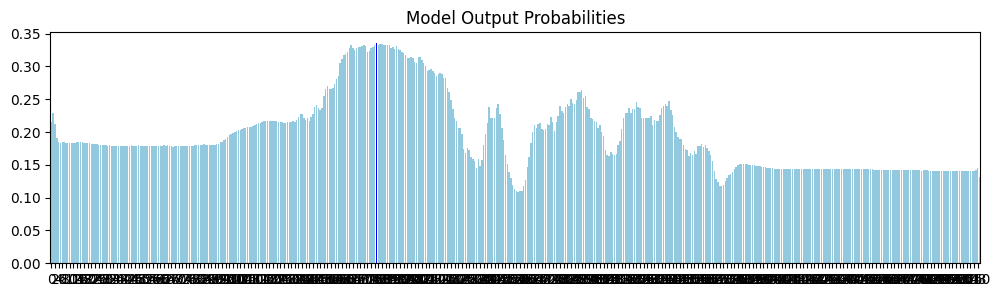

In [46]:
random_img_id = np.random.choice(list(images.keys()))
plot_frame_selection("131aedfhs6pnf1fvtvp49h4bhdjeabmt22")

In [12]:
def imshow_frames(img_id, frames):
    img = images[img_id] 
    
    fig, axes = plt.subplots(1, len(frames), figsize=(3 * len(frames),  3))
    axes = axes.flatten() if len(frames) > 1 else [axes]
    
    for ax, frame in zip(axes, frames):
        ax.imshow(img[frame])
        ax.axis('off')
        ax.text(0.1, 0.1, str(frame), fontsize=14, color='white', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

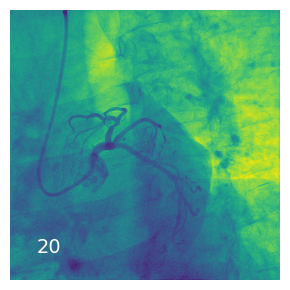

In [43]:
random_img_id = np.random.choice(list(images.keys()))
imshow_frames(random_img_id, [20])

In [56]:
def top_k_accuracy():
    positions = []
    for img_id in tqdm(images):
        img = images[img_id]
        img = torch.tensor(img).to(device).unsqueeze(1)
        probs = torch.sigmoid(model(img))
        probs = probs.squeeze(1).cpu().numpy()

        try:
            selected = df.loc[img_id, "SELECTEDFRAME"]
            selected = selected.values if type(selected)!=np.int64 else [selected]
            pos = min([list(np.argsort(-probs)).index(s) for s in selected])
            positions.append(pos)
        except Exception:
            pass

    positions = np.array(positions)

    print(f"top1: {(positions<1).mean()}")
    print(f"top3: {(positions<3).mean()}")
    print(f"top5: {(positions<5).mean()}")
    print(f"top10: {(positions<10).mean()}")
    

In [57]:
top_k_accuracy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:10<00:00, 10.37it/s]

top1: 0.07920792079207921
top3: 0.16831683168316833
top5: 0.2871287128712871
top10: 0.48514851485148514
